In [1]:
import sys
import os

# Get the current working directory (where the notebook is located)
curr_dir = os.getcwd()


# Add the project root to the system path
project_root = os.path.abspath(os.path.join(curr_dir, '..'))
sys.path.append(project_root)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import matplotlib.pyplot as plt
from tueplots import bundles
import src.BikeDataPlotter as BikePlotter
import src.EventsDataPlotter as EventsPlotter
import src.Colortheme as ct

import numpy as np
from shapely.geometry import LineString

from src.LoadEventsData import EventsData
from src.LoadEcoCounterData import EcoCounterData as BikeData

In [2]:
bd = BikeData()
ed = EventsData()

In [3]:
hourly_bike_data = bd.get_hourly_data()
hourly_bike_data.set_index("iso_timestamp", inplace=True)

In [4]:
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.framealpha'] = .8
plt.rcParams.update({"figure.dpi": 200})

In [5]:
def create_avg_weekday_plot(stylesheet, wd, counter_id=None, years=None, plot_dir=False, ymax=None):
    importlib.reload(ct)
    importlib.reload(BikePlotter)
    importlib.reload(EventsPlotter)
    
    weekday_data = hourly_bike_data.copy()
    weekday_data = weekday_data[weekday_data["weekday"] == wd]
    if counter_id is not None:
        weekday_data = weekday_data[weekday_data["counter_site_id"].isin(counter_id)]
    if years is not None:
        weekday_data = weekday_data[weekday_data.index.year.isin(years)]
    if weekday_data.empty:
        print("No data for given parameters")
        return
    weekday_mean = weekday_data.groupby(weekday_data.index.hour)["zählstand"].mean()
    in_data = weekday_data[weekday_data["channel_id"] == "in"].copy()
    in_mean = in_data.groupby(in_data.index.hour)["zählstand"].mean()
    out_data = weekday_data[weekday_data["channel_id"] == "out"].copy()
    out_mean = out_data.groupby(out_data.index.hour)["zählstand"].mean()
    wd_data = [weekday_mean,in_mean,out_mean]
    
    plt.rcParams.update(stylesheet)
    figinfo = plt.subplots(1, 1)
    
    BikePlotter.plot_avg_weekday(wd_data, wd, figinfo, years=years, counter_id=counter_id, plot_directions=plot_dir, ymax=ymax)
    plt.show()

# Day Analysis

As we have seen in the previous evaluations workdays and weekend days differ in the amount of bike traffic. In this evaluation we will construct a typical workday from the data and compare it to a typical weekend day. First we will have a look at the hourly counts of an average weekday. As in `eva_3_WeekAnalysis.ipynb` we will combine the data from Fahrradtunnel and Steinlachallee.

In [6]:
# city counters
STYLE_7_DAYS = bundles.beamer_moml(rel_width=1.1, rel_height=1)
for d in range(7):
    create_avg_weekday_plot(STYLE_7_DAYS, wd=0, counter_id=[100003358, 100003359], plot_dir=True, ymax=325)

NameError: name 'importlib' is not defined

__Observations__:
- as expected, the curves for the Fahrradtunnel and Steinlachallee are very similar on weekdays (Monday to Friday)
- workdays show a clear pattern with two peaks (rush hours) in the morning (6am to 9am) and afternoon (3pm to 6pm)
- it is interesting to have a look at the crossing points of the directions. On workdays, the first crossing (from this point more people head into the city) is between 3am and 4am. The second crossing (more people leave the city) is between 3pm and 4pm. Sometimes there is a short period at noon where the amount of counts is approximately equal in both directions. This shows, that most people counted are on their way to work, school or university in the morning and on their way back home in the afternoon. On Fridays the second crossing is shifted to the window from 12am to 1pm. This is probably due to people leaving work earlier on Fridays
- On weekends the first crossing is between 4am and 5am for both days. On Saturdays 12am to 9pm four crossings occur where the "main direction trend" swaps. This is likely due to the different reasons for people to use their bike on Saturdays. Some might have to work, they appear earlier in the day and might have to work just half a day and head back at noon. Others go shopping or meet friends in the city and appear later in the afternoon. In the evening they head back home, but nightlife starts, which might be another reason for people coming into the city. On Sundays the ratio of people coming into the city and leaving the city in the afternoon is more balanced.

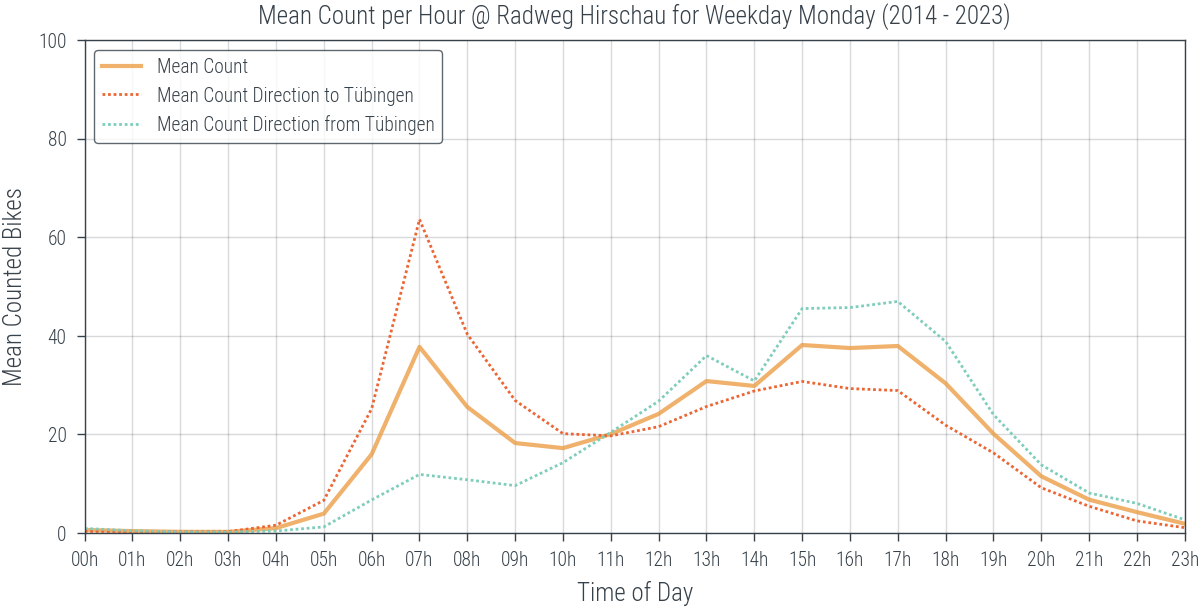

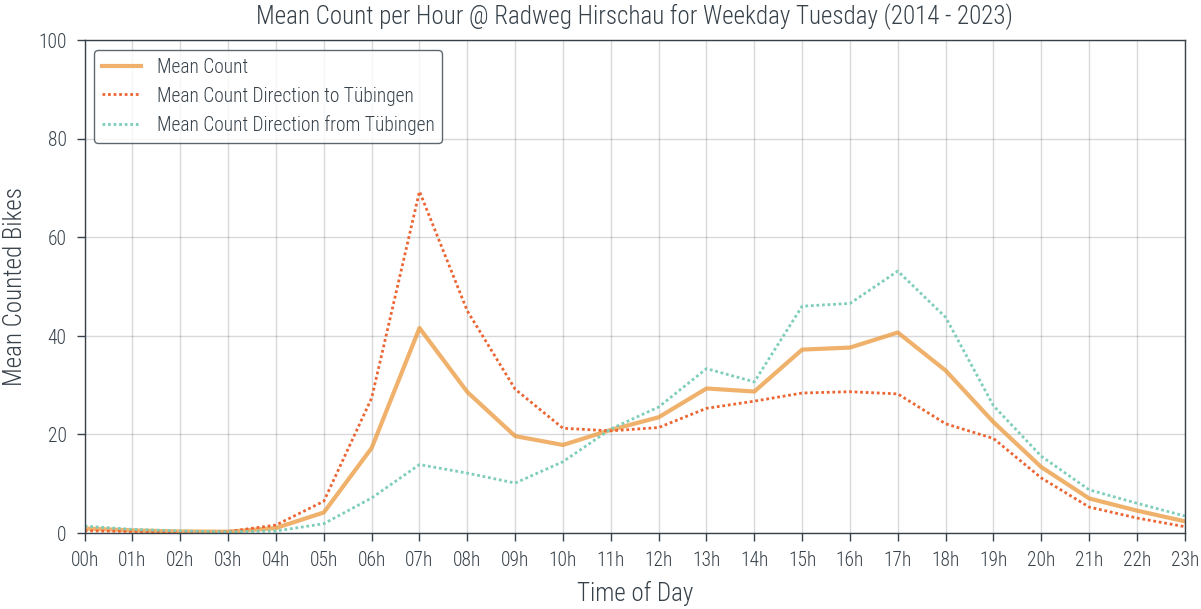

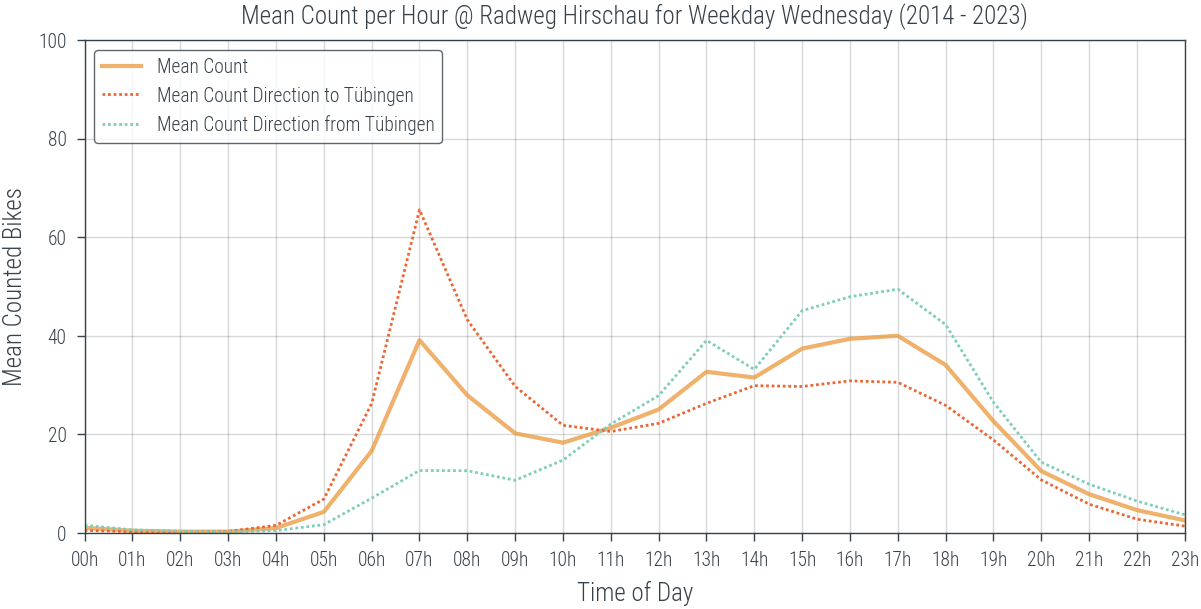

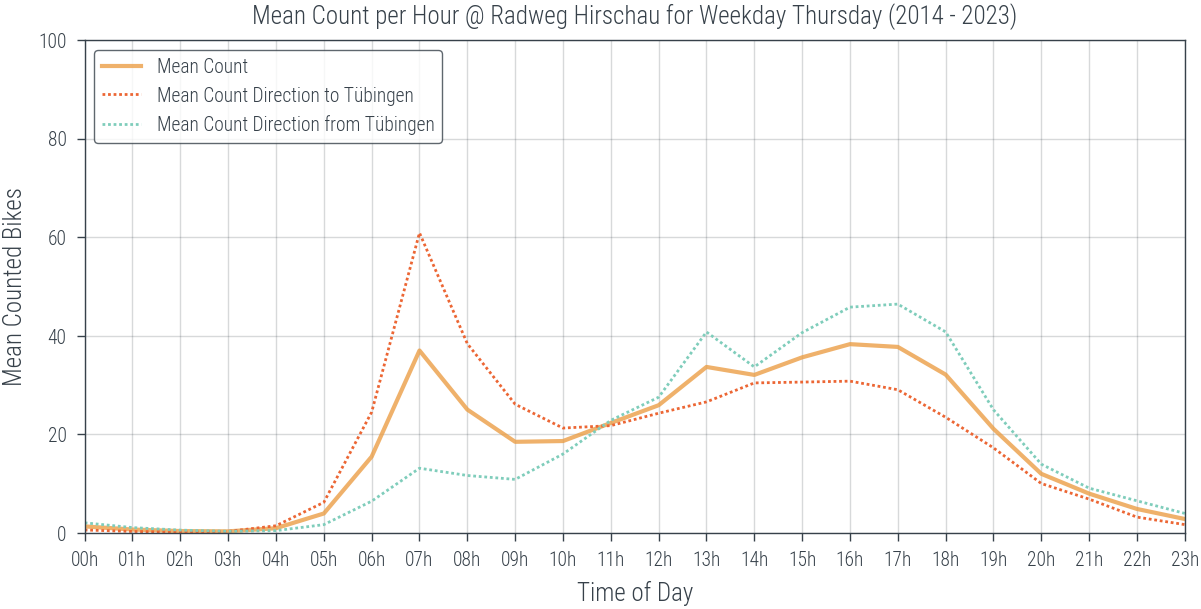

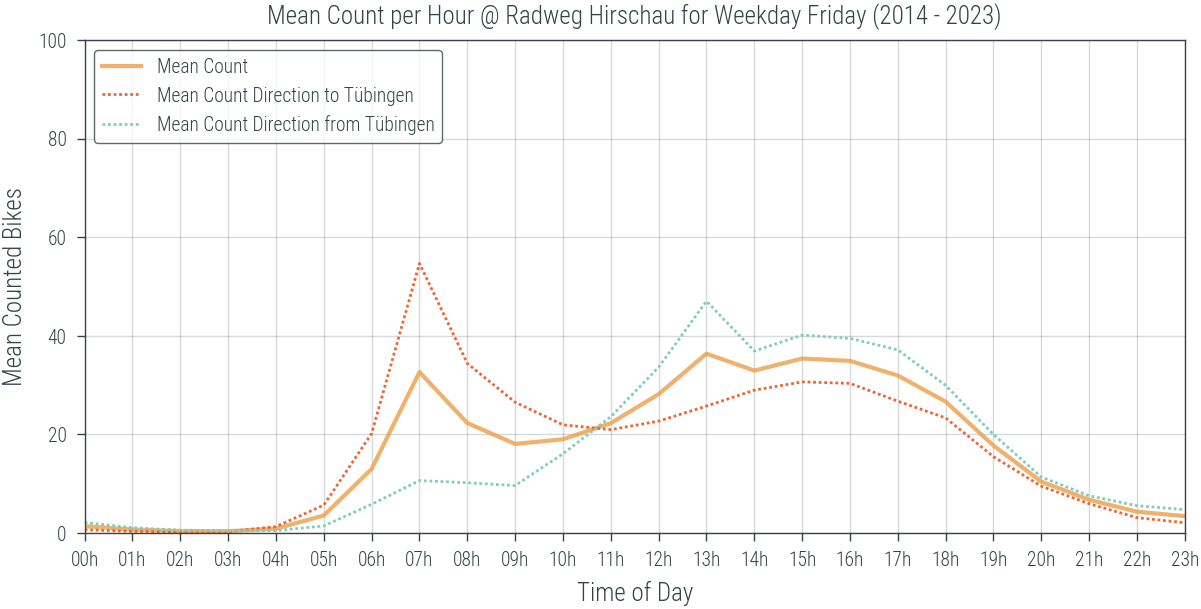

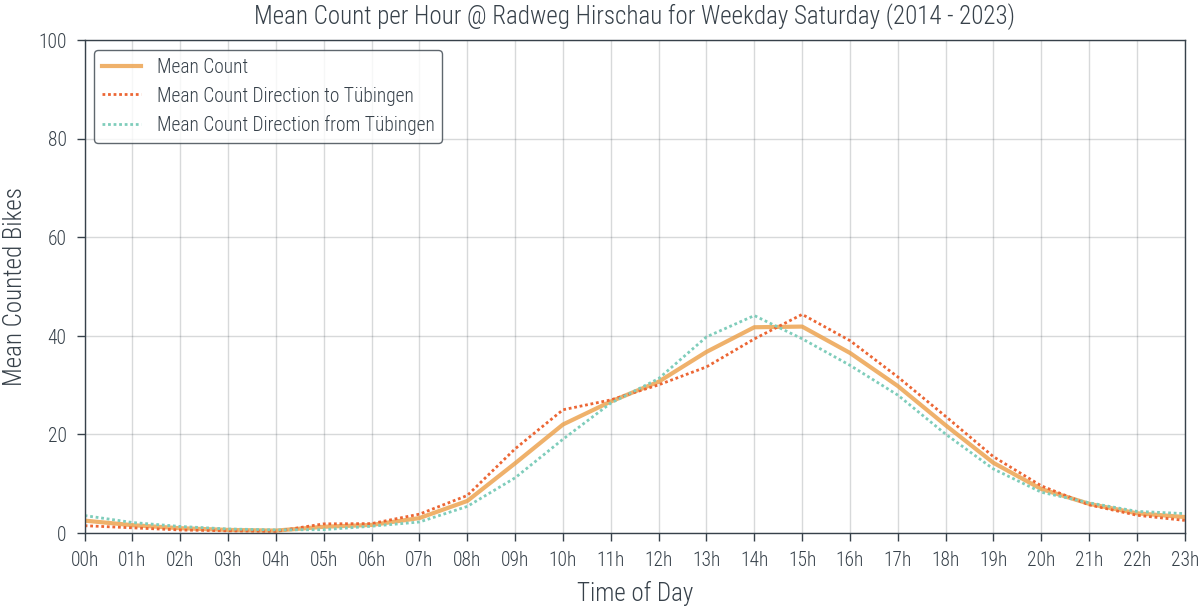

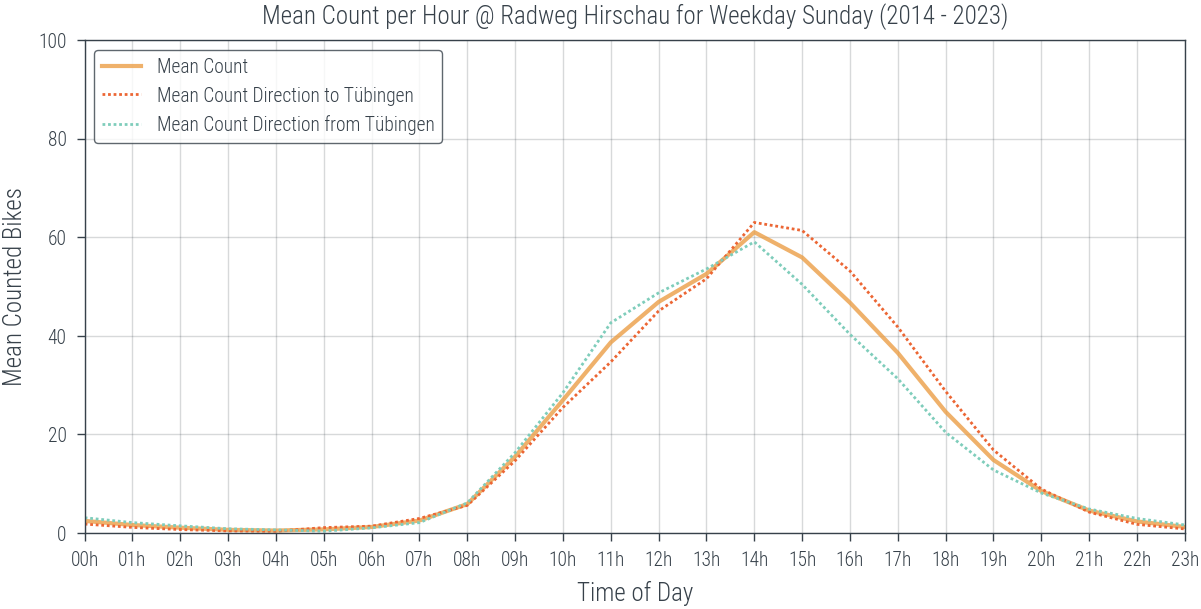

In [ ]:
# Hirschau counter
for d in range(7):
    create_avg_weekday_plot(STYLE_7_DAYS, wd=d, counter_id=[100026408], plot_dir=True, ymax=100)

__Observations__:
- the Hirschau counter shows a similar weekday pattern concerning the rush hours as the city counters, but with another magnitude
- the second crossing is much earlier
- on weekends the count trends have a single peak on Saturday and Sunday between 2pm and 3pm. This again reinforces the theory that Hirschau mainly counts cyclists who cycle in their free time.
- furthermore, the direction ratio is very homogeneous, as the difference between both mean counts is always relatively small.

## Overall Observations and Conclusions

- the usual working and school hours dominate the weekdays and create a measurable rush hour in the mornings and evenings
- more people drive into the city in the morning and a similar amount of people leave in the evening. This supports the assumption that the typical cyclist in Tübingen uses the bike to get to work, school or university.
It is also interesting to see at what time the directional relationship flips and that it shifts forward on Fridays, as many people finish work earlier on this day
- the weekends show that some people still cycle to work or shopping on Saturday mornings. But above all, most of the traffic only takes place in the afternoon. The ratio of cyclists leaving and entering the city is also very balanced on the weekends

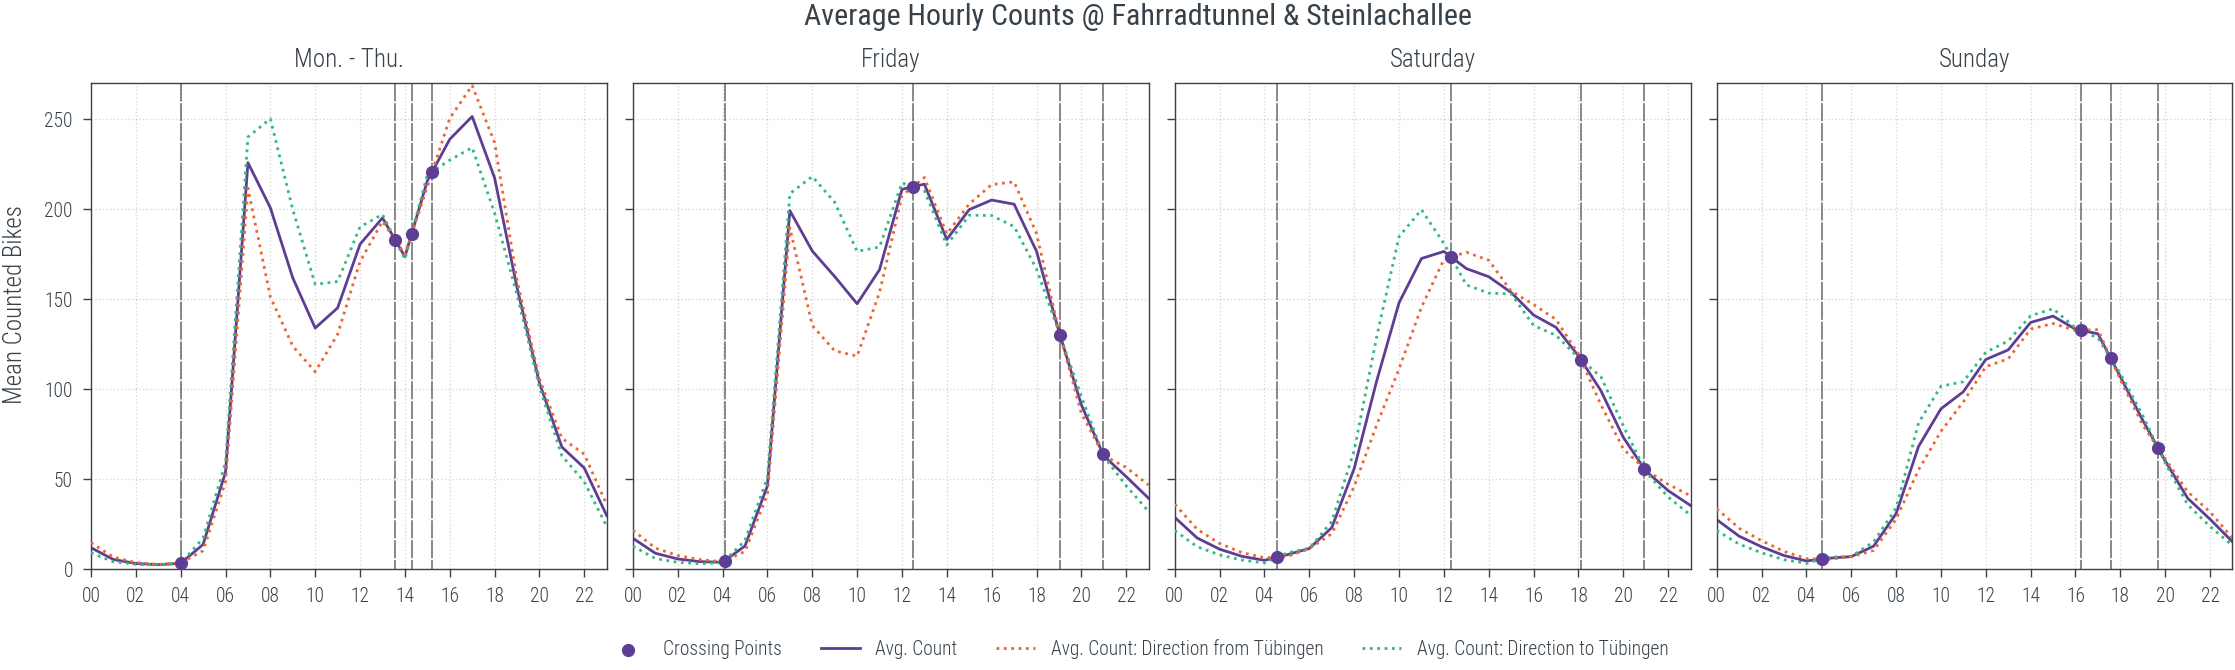

In [ ]:
STYLE_7_DAYS = bundles.beamer_moml(rel_width=1, rel_height=1)
plt.rcParams.update(STYLE_7_DAYS)
df = bd.get_hourly_data(counter_id=[100003358, 100003359])

weekdays = df[df["weekday"].isin([0, 1, 2, 3])].copy()
friday = df[df["weekday"] == 4].copy()
saturday = df[df["weekday"] == 5].copy()
sunday = df[df["weekday"] == 6].copy()
data = [weekdays, friday, saturday, sunday]

plt.rcParams.update(bundles.beamer_moml(rel_width=2, rel_height=1))
fig, axs = plt.subplots(1,4, sharey=True)
axs = axs.flatten()

labels = ["Mon. - Thu.", "Friday", "Saturday", "Sunday"]
msz = 2
lw = .65
alph = 0.8
alph_fill = 0.1
colors = [ct.PRIMARY_COLORS[2], ct.PRIMARY_COLORS[1],
          ct.COUNTER_COLORS[3], ct.AREA_COLORS[0],]
linestyles = [(0, (1, 1)), (0, (1, 1)), "-"]

for i, ax in enumerate(axs):
    weekday_data = data[i].copy()
    weekday_data.set_index("iso_timestamp", inplace=True)
    weekday_mean = weekday_data.groupby(weekday_data.index.hour)["zählstand"].mean()
    in_data = weekday_data[weekday_data["channel_id"] == "in"].copy()
    in_mean = in_data.groupby(in_data.index.hour)["zählstand"].mean()
    out_data = weekday_data[weekday_data["channel_id"] == "out"].copy()
    out_mean = out_data.groupby(out_data.index.hour)["zählstand"].mean()
    
    ax.plot(
        in_mean.index,
        in_mean,
        color=colors[0],label="Avg. Count: Direction to Tübingen",
        linestyle="dotted",
        zorder=5
    )
    ax.plot(
        out_mean.index,out_mean,
        color=colors[1],label="Avg. Count: Direction from Tübingen",
        linestyle="dotted",
        zorder=5
    )
    # !COUNTER!
    ax.plot( 
        weekday_mean.index,weekday_mean,
        color=colors[2],
        label="Avg. Count",
        zorder=0
    )
    
    # get intersections
    first_line = LineString(np.column_stack((in_mean.index, in_mean.values)))
    second_line = LineString(np.column_stack((out_mean.index, out_mean.values)))
    intersection = first_line.intersection(second_line)
    intersection_points = [p.coords[0] for p in intersection.geoms]
    ax.scatter(
        *zip(*intersection_points),
        color=colors[2], 
        s=18,
        marker="o",
        label="Crossing Points",
        alpha=1,
        zorder=10
    )
    has_label = True
    for x, y in intersection_points:
        label = "_nolabel_"
        if has_label:
            label = "Crossing Points"
            has_label = False
        ax.axvline(x, color="black", linestyle=(5,(10,1)), alpha=0.5, zorder=0, label=label, lw=0.65)
    
    ax.set_title(labels[i])
    # if i % 2 == 0:
    #     ax.set_ylabel("Avg. Counted Bikes")
    # if i >= 2:
    #     ax.set_xlabel("Hour of Day")
    ax.grid(ls=":")
    ax.set_ylim(0, 270)
    ax.set_xticks(range(0, 24, 2))
    ax.set_xticklabels([f"{h:02d}" for h in range(0, 24, 2)])
    ax.set_xlim(0, 23)

# fig.text(0.5, -0.05, 'Hour of Day', ha='center')
fig.text(-0.015, 0.5, 'Mean Counted Bikes', va='center', rotation='vertical')

handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
unique.reverse()
fig.legend(*zip(*unique), bbox_to_anchor=(0.5,-.1), loc="lower center", ncol=5, frameon=False)
# TODO: LABEL NEEDED?
plt.suptitle("Average Hourly Counts @ Fahrradtunnel & Steinlachallee")
plt.show()

## 2x2 Version

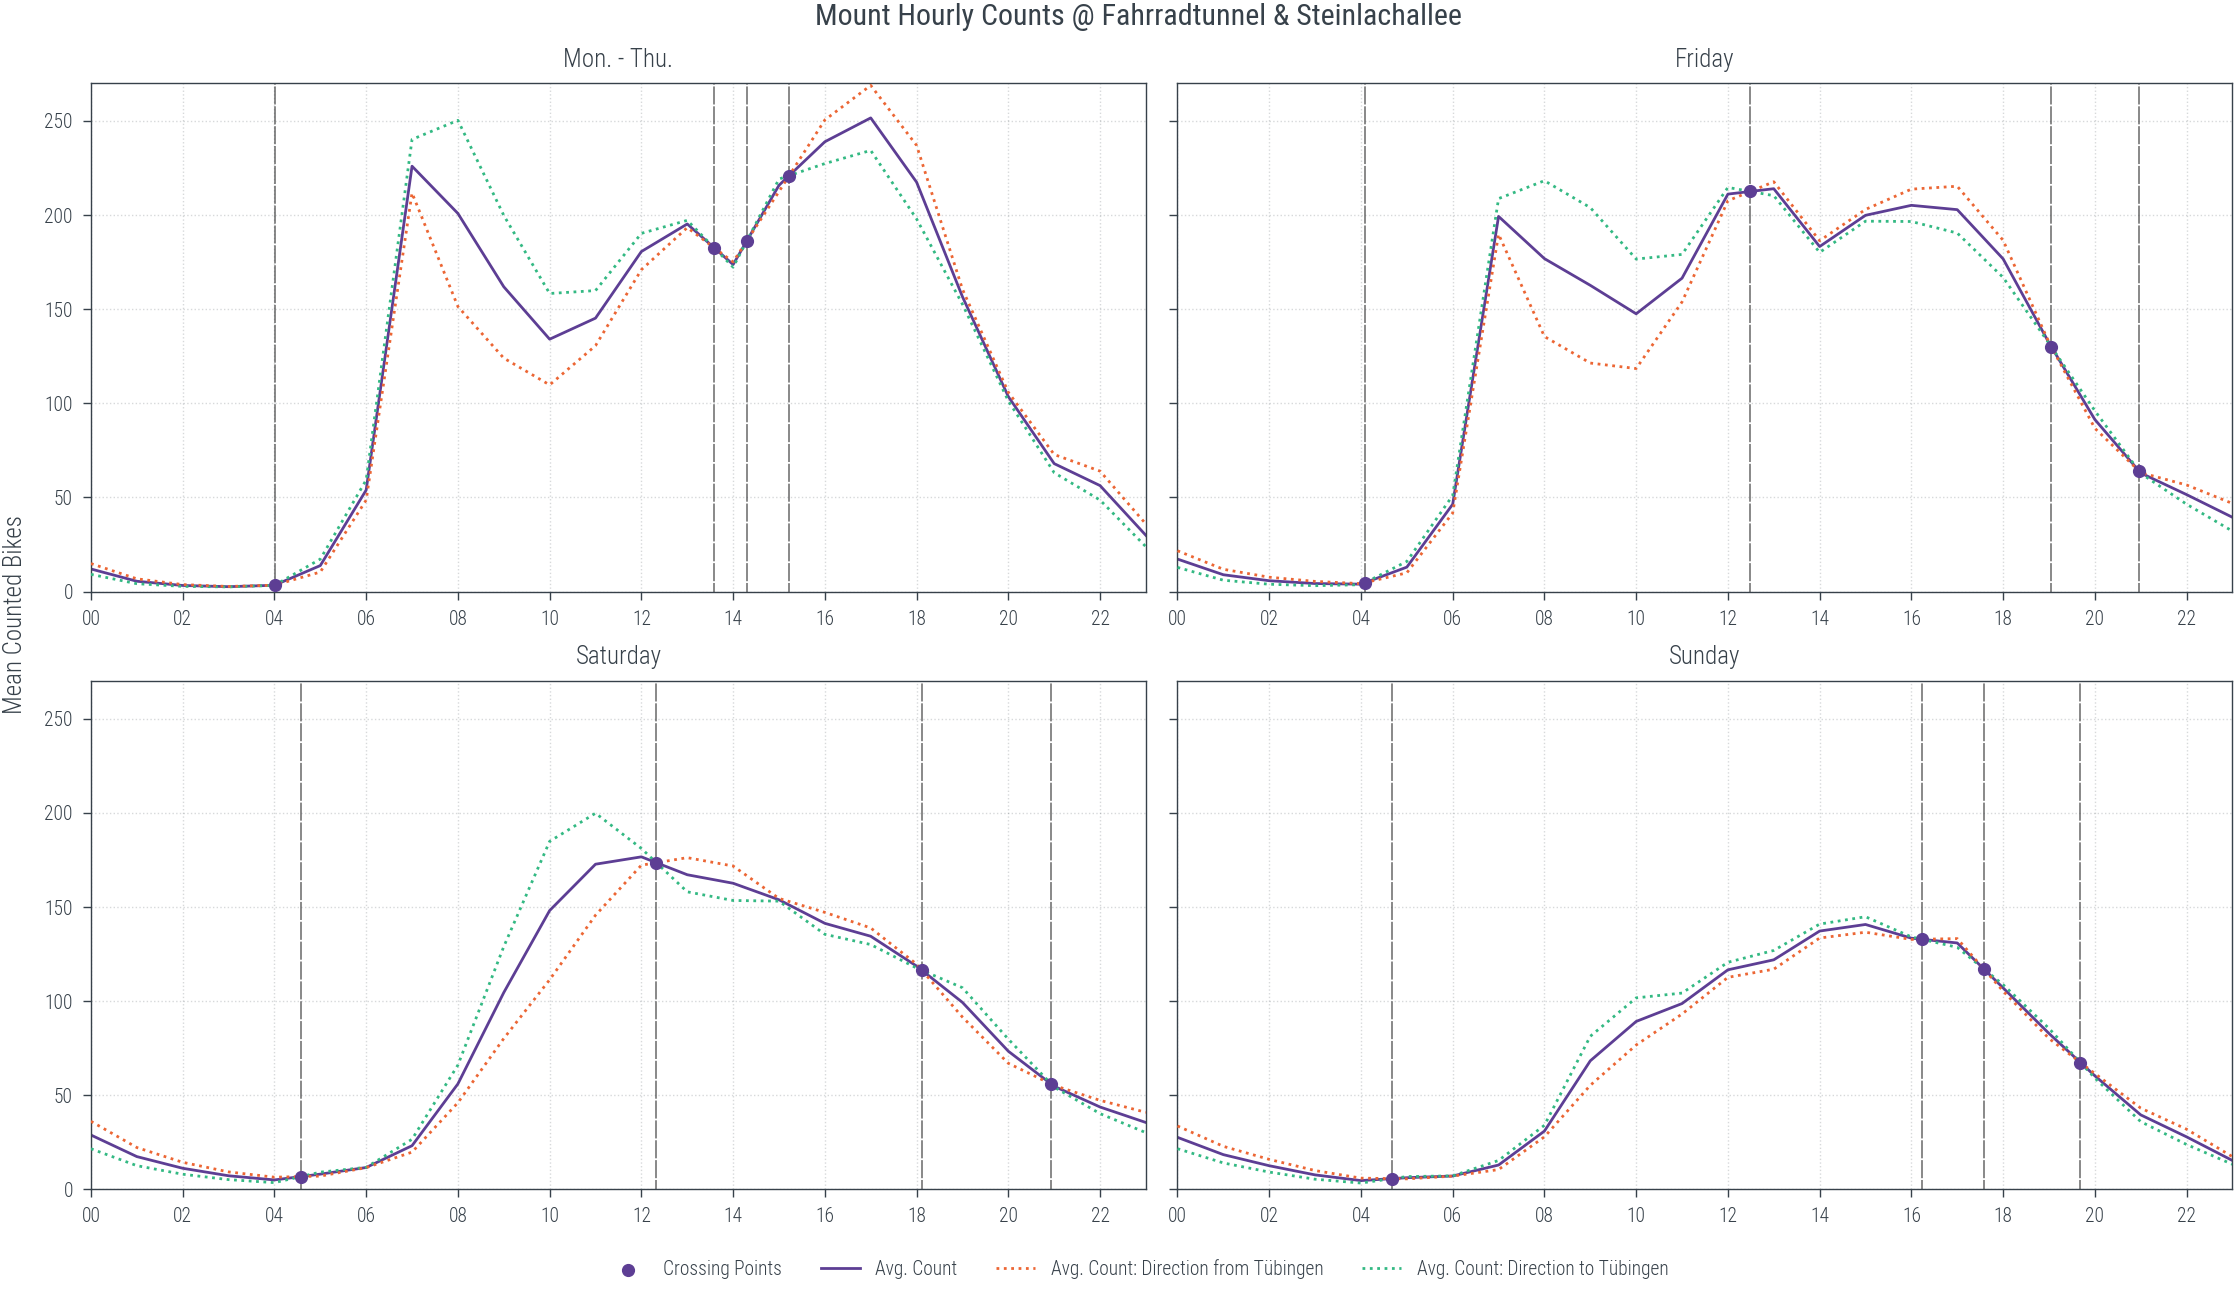

In [8]:
STYLE_7_DAYS = bundles.beamer_moml(rel_width=1, rel_height=1.2)
plt.rcParams.update(STYLE_7_DAYS)
df = bd.get_hourly_data(counter_id=[100003358, 100003359])

weekdays = df[df["weekday"].isin([0, 1, 2, 3])].copy()
friday = df[df["weekday"] == 4].copy()
saturday = df[df["weekday"] == 5].copy()
sunday = df[df["weekday"] == 6].copy()
data = [weekdays, friday, saturday, sunday]

plt.rcParams.update(bundles.beamer_moml(rel_width=2, rel_height=2))
fig, axs = plt.subplots(2,2, sharey=True)
axs = axs.flatten()

labels = ["Mon. - Thu.", "Friday", "Saturday", "Sunday"]
msz = 2
lw = .65
alph = 0.8
alph_fill = 0.1
colors = [ct.PRIMARY_COLORS[2], ct.PRIMARY_COLORS[1],
          ct.COUNTER_COLORS[3], ct.AREA_COLORS[0],]
linestyles = [(0, (1, 1)), (0, (1, 1)), "-"]

for i, ax in enumerate(axs):
    weekday_data = data[i].copy()
    weekday_data.set_index("iso_timestamp", inplace=True)
    weekday_mean = weekday_data.groupby(weekday_data.index.hour)["zählstand"].mean()
    in_data = weekday_data[weekday_data["channel_id"] == "in"].copy()
    in_mean = in_data.groupby(in_data.index.hour)["zählstand"].mean()
    out_data = weekday_data[weekday_data["channel_id"] == "out"].copy()
    out_mean = out_data.groupby(out_data.index.hour)["zählstand"].mean()
    
    ax.plot(
        in_mean.index,
        in_mean,
        color=colors[0],label="Avg. Count: Direction to Tübingen",
        linestyle="dotted",
        zorder=5
    )
    ax.plot(
        out_mean.index,out_mean,
        color=colors[1],label="Avg. Count: Direction from Tübingen",
        linestyle="dotted",
        zorder=5
    )
    # !COUNTER!
    ax.plot( 
        weekday_mean.index,weekday_mean,
        color=colors[2],
        label="Avg. Count",
        zorder=0
    )
    
    # get intersections
    first_line = LineString(np.column_stack((in_mean.index, in_mean.values)))
    second_line = LineString(np.column_stack((out_mean.index, out_mean.values)))
    intersection = first_line.intersection(second_line)
    intersection_points = [p.coords[0] for p in intersection.geoms]
    ax.scatter(
        *zip(*intersection_points),
        color=colors[2], 
        s=18,
        marker="o",
        label="Crossing Points",
        alpha=1,
        zorder=10
    )
    has_label = True
    for x, y in intersection_points:
        label = "_nolabel_"
        if has_label:
            label = "Crossing Points"
            has_label = False
        ax.axvline(x, color="black", linestyle=(5,(10,1)), alpha=0.5, zorder=0, label=label, lw=0.65)
    
    ax.set_title(labels[i])
    # if i % 2 == 0:
    #     ax.set_ylabel("Avg. Counted Bikes")
    # if i >= 2:
    #     ax.set_xlabel("Hour of Day")
    ax.grid(ls=":")
    ax.set_ylim(0, 270)
    ax.set_xticks(range(0, 24, 2))
    ax.set_xticklabels([f"{h:02d}" for h in range(0, 24, 2)])
    ax.set_xlim(0, 23)

# fig.text(0.5, -0.05, 'Hour of Day', ha='center')
fig.text(-0.015, 0.5, 'Mean Counted Bikes', va='center', rotation='vertical')

handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
unique.reverse()
fig.legend(*zip(*unique), bbox_to_anchor=(0.5,-.05), loc="lower center", ncol=5, frameon=False)

plt.suptitle("Mount Hourly Counts @ Fahrradtunnel & Steinlachallee")
plt.show()